<a href="https://colab.research.google.com/github/CowPeas/multi-modal-transformers/blob/master/maestro_florence2_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Dec  3 21:25:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   60C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install dependencies

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install --no-deps git+https://github.com/roboflow/maestro.git@fix/dependencies

  Cloning https://github.com/roboflow/maestro.git (to revision fix/dependencies) to /tmp/pip-req-build-jd9877bw
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/maestro.git /tmp/pip-req-build-jd9877bw
  Running command git checkout -b fix/dependencies --track origin/fix/dependencies
  Switched to a new branch 'fix/dependencies'
  Branch 'fix/dependencies' set up to track remote branch 'fix/dependencies' from 'origin'.
  Resolved https://github.com/roboflow/maestro.git to commit 71d8467e54a4d5aa0c075a45ed8e567eaa1838e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for maestro: filename=maestro-0.2.0rc5-py3-none-any.whl size=43123 sha256=b515e5c433a5d880e456bb47cd476dbf8e876517a1533c6a9a09036bc271dae8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8uzjyfyo/wheels/61/78/ed/8f0d548bf3918cd078f6d947076f2ef04f1c8f8afdc6ffeb28
Successfully built maestro

In [ ]:
!pip install -q transformers flash_attn timm einops jiwer typer==0.12.5 supervision==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
maestro 0.2.0rc5 requires accelerate<1.1,>=0.33, but you have accelerate 1.1.1 which is incompatible.
maestro 0.2.0rc5 requires flash-attn~=2.6.3; sys_platform != "darwin", but you have flash-attn 2.7.0.post2 which is incompatible.
maestro 0.2.0rc5 requires torch~=2.4.0, but you have torch 2.5.1+cu121 which is incompatible.
maestro 0.2.0rc5 requires transformers<4.46.0,>=4.44.2, but you have transformers 4.46.2 which is incompatible.


## Download dataset

In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

version = rf.workspace("roboflow-jvuqo").project("pallet-load-manifest").version(6)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pallet-load-manifest-6 in jsonl:: 100%|██████████| 118/118 [00:00<00:00, 492.95it/s]


In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_2998_JPG.rf.11bc1ae82dae6d20b38a0d2ed385c4e7.jpg","prefix":"JSON","suffix":"{\n    \"route\": \"X804-LA-607\",\n    \"pallet_number\": \"9\",\n    \"delivery_date\": \"2/21/2024\",\n    \"load\": \"4\",\n    \"dock\": \"D76\",\n    \"shipment_id\": \"V86675728950\",\n    \"destination\": \"7281 Daniel Port Suite 658, Smithshire, WY 97176\",\n    \"asn_number\": \"8872055787\",\n    \"salesman\": \"BRIAN HENDRIX\",\n    \"products\": [\n        {\n            \"description\": \"271828 - CASE OF GARBAGE BAGS\",\n            \"cases\": \"2\",\n            \"sales_units\": \"16\",\n            \"layers\": \"5\"\n        },\n        {\n            \"description\": \"369852 - 24PK OF SPONGE SCOURERS\",\n            \"cases\": \"16\",\n            \"sales_units\": \"64\",\n            \"layers\": \"2\"\n        },\n        {\n            \"description\": \"852147 - CASE OF BLEACH\",\n            \"cases\": \"16\",\n            \"sales_units\": \"16\",\n            \"layers\": \"

In [ ]:
!sed -i 's/\\n//g; s/  //g' {dataset.location}/train/annotations.jsonl
!sed -i 's/\\n//g; s/  //g' {dataset.location}/test/annotations.jsonl
!sed -i 's/\\n//g; s/  //g' {dataset.location}/valid/annotations.jsonl

In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_2998_JPG.rf.11bc1ae82dae6d20b38a0d2ed385c4e7.jpg","prefix":"JSON","suffix":"{\"route\": \"X804-LA-607\",\"pallet_number\": \"9\",\"delivery_date\": \"2/21/2024\",\"load\": \"4\",\"dock\": \"D76\",\"shipment_id\": \"V86675728950\",\"destination\": \"7281 Daniel Port Suite 658, Smithshire, WY 97176\",\"asn_number\": \"8872055787\",\"salesman\": \"BRIAN HENDRIX\",\"products\": [{\"description\": \"271828 - CASE OF GARBAGE BAGS\",\"cases\": \"2\",\"sales_units\": \"16\",\"layers\": \"5\"},{\"description\": \"369852 - 24PK OF SPONGE SCOURERS\",\"cases\": \"16\",\"sales_units\": \"64\",\"layers\": \"2\"},{\"description\": \"852147 - CASE OF BLEACH\",\"cases\": \"16\",\"sales_units\": \"16\",\"layers\": \"5\"},{\"description\": \"759384 - BOX OF STORAGE BINS\",\"cases\": \"64\",\"sales_units\": \"32\",\"layers\": \"2\"},{\"description\": \"657483 - 12PK OF WAX APPLICATORS\",\"cases\": \"2\",\"sales_units\": \"2\",\"layers\": \"3\"},{\"description\": \"852147 - CASE OF BLEACH\",\

**NOTE:** The downloaded dataset is in raw JSONL format. To remain consistent with the Florence-2 convention, we will prefix each prefix with the name of the vision task being performed. In our case, this will be `<VQA>`.

In [ ]:
import json
import os
from typing import Any


def modify_jsonl(file_path: str, task: str) -> None:
    """Modify each line of a JSONL file by prepending a task string to the 'prefix' value.

    Args:
        file_path (str): Path to the JSONL file to modify.
        task (str): The string to prepend to each 'prefix' value in the JSONL file.

    Returns:
        None
    """
    temp_file_path: str = file_path + ".temp"

    with open(file_path) as infile, open(temp_file_path, "w") as outfile:
        for line in infile:
            data: dict[str, Any] = json.loads(line.strip())
            data["prefix"] = f"{task}"
            outfile.write(json.dumps(data) + "\n")

    os.replace(temp_file_path, file_path)

In [ ]:
modify_jsonl(f"{dataset.location}/train/annotations.jsonl", "<JSON>")
modify_jsonl(f"{dataset.location}/test/annotations.jsonl", "<JSON>")
modify_jsonl(f"{dataset.location}/valid/annotations.jsonl", "<JSON>")

In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image": "IMG_2998_JPG.rf.11bc1ae82dae6d20b38a0d2ed385c4e7.jpg", "prefix": "<JSON>", "suffix": "{\"route\": \"X804-LA-607\",\"pallet_number\": \"9\",\"delivery_date\": \"2/21/2024\",\"load\": \"4\",\"dock\": \"D76\",\"shipment_id\": \"V86675728950\",\"destination\": \"7281 Daniel Port Suite 658, Smithshire, WY 97176\",\"asn_number\": \"8872055787\",\"salesman\": \"BRIAN HENDRIX\",\"products\": [{\"description\": \"271828 - CASE OF GARBAGE BAGS\",\"cases\": \"2\",\"sales_units\": \"16\",\"layers\": \"5\"},{\"description\": \"369852 - 24PK OF SPONGE SCOURERS\",\"cases\": \"16\",\"sales_units\": \"64\",\"layers\": \"2\"},{\"description\": \"852147 - CASE OF BLEACH\",\"cases\": \"16\",\"sales_units\": \"16\",\"layers\": \"5\"},{\"description\": \"759384 - BOX OF STORAGE BINS\",\"cases\": \"64\",\"sales_units\": \"32\",\"layers\": \"2\"},{\"description\": \"657483 - 12PK OF WAX APPLICATORS\",\"cases\": \"2\",\"sales_units\": \"2\",\"layers\": \"3\"},{\"description\": \"852147 - CASE OF BLE

## Fine-tune Florence-2 on JSON data extraction dataset

In [ ]:
!maestro --help

                                                                                                    
 Usage: maestro [OPTIONS] COMMAND [ARGS]...                                                         
                                                                                                    
╭─ Options ────────────────────────────────────────────────────────────────────────────────────────╮
│ --install-completion          Install completion for the current shell.                          │
│ --show-completion             Show completion for the current shell, to copy it or customize the │
│                               installation.                                                      │
│ --help                        Show this message and exit.                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ Commands ───────────────────────────────────────────────────────────────────────────────

In [ ]:
!maestro florence2 train --help

                                                                                                    
 Usage: maestro florence2 train [OPTIONS]                                                           
                                                                                                    
 Train Florence 2 model                                                                             
                                                                                                    
╭─ Options ────────────────────────────────────────────────────────────────────────────────────────╮
│ *  --dataset                                 TEXT     Path to the dataset used for training      │
│                                                       [default: None]                            │
│                                                       [required]                                 │
│    --model_id                                TEXT     Identifier for the Florence-2 model

In [ ]:
!maestro florence2 train --dataset={dataset.location} \
--epochs=20 --batch_size=6 --lr=2e-4 \
--metrics word_error_rate --metrics character_error_rate

Training configuration
{
    'dataset': '/content/pallet-load-manifest-6',
    'model_id': 'microsoft/Florence-2-base-ft',
    'revision': 'refs/pr/20',
    'device': device(type='cuda', index=0),
    'cache_dir': None,
    'epochs': 20,
    'optimizer': 'adamw',
    'lr': 0.0002,
    'lr_scheduler': 'linear',
    'batch_size': 6,
    'val_batch_size': None,
    'num_workers': 0,
    'val_num_workers': None,
    'lora_r': 8,
    'lora_alpha': 8,
    'lora_dropout': 0.05,
    'bias': 'none',
    'use_rslora': True,
    'init_lora_weights': 'gaussian',
    'output_dir': './training/florence-2',
    'metrics': [
    ]
}
preprocessor_config.json: 100% 806/806 [00:00<00:00, 6.09MB/s]
processing_florence2.py: 100% 46.4k/46.4k [00:00<00:00, 6.56MB/s]
tokenizer_config.json: 100% 34.0/34.0 [00:00<00:00, 232kB/s]
vocab.json: 100% 1.10M/1.10M [00:00<00:00, 5.48MB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 5.27MB/s]
config.json: 100% 2.43k/2.43k [00:00<00:00, 18.1MB/s]
configuration_florenc

## Evaluate Florence-2 on JSON data extraction dataset

In [ ]:
!ls -la training/florence-2/1/metrics/

total 168
drwxr-xr-x 2 root root  4096 Dec  3 21:49 .
drwxr-xr-x 4 root root  4096 Dec  3 21:49 ..
-rw-r--r-- 1 root root 41948 Dec  3 21:49 cer_plot.png
-rw-r--r-- 1 root root 32252 Dec  3 21:49 loss_plot.png
-rw-r--r-- 1 root root 37339 Dec  3 21:49 training.json
-rw-r--r-- 1 root root  6562 Dec  3 21:49 validation.json
-rw-r--r-- 1 root root 36095 Dec  3 21:49 wer_plot.png


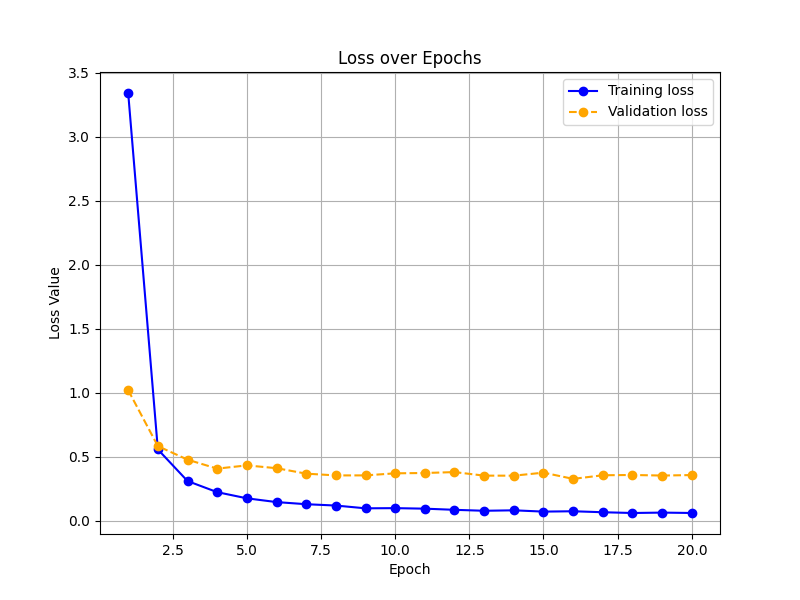

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/loss_plot.png", height=600)

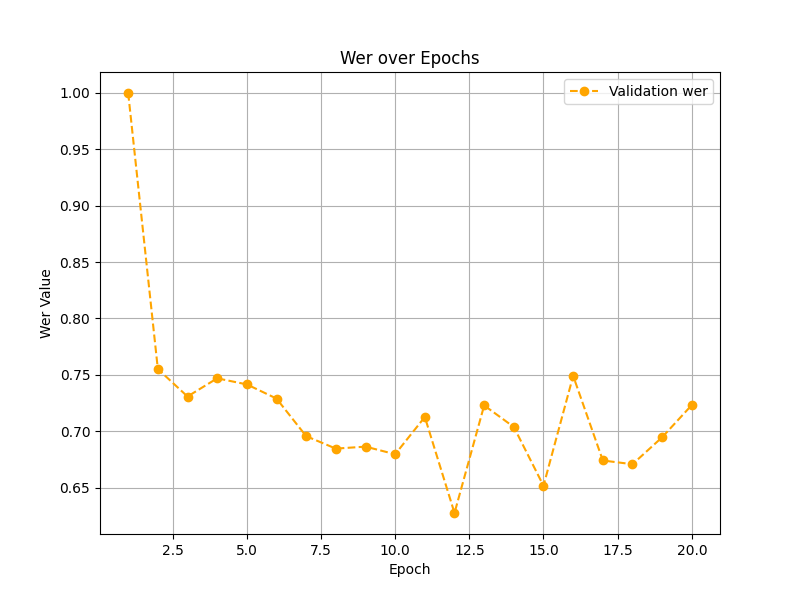

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/wer_plot.png", height=600)

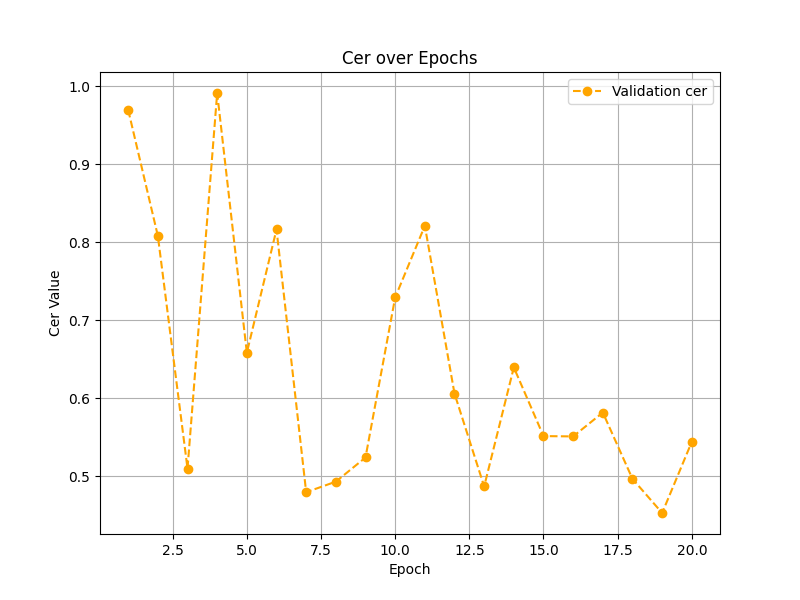

In [ ]:
from IPython.display import Image

Image(filename="training/florence-2/1/metrics/cer_plot.png", height=600)

In [ ]:
!ls -la training/florence-2/1/checkpoints/

total 16
drwxr-xr-x 4 root root 4096 Dec  3 21:28 .
drwxr-xr-x 4 root root 4096 Dec  3 21:49 ..
drwxr-xr-x 2 root root 4096 Dec  3 21:28 best
drwxr-xr-x 2 root root 4096 Dec  3 21:28 latest


In [ ]:
!maestro florence2 evaluate \
--dataset={dataset.location} \
--model_id=/content/training/florence-2/1/checkpoints/best \
--metrics word_error_rate --metrics character_error_rate

Evaluation configuration
{
    'dataset': '/content/pallet-load-manifest-6',
    'model_id': '/content/training/florence-2/1/checkpoints/best',
    'revision': 'refs/pr/20',
    'device': device(type='cuda', index=0),
    'cache_dir': None,
    'epochs': 10,
    'optimizer': 'adamw',
    'lr': 1e-05,
    'lr_scheduler': 'linear',
    'batch_size': 4,
    'val_batch_size': None,
    'num_workers': 0,
    'val_num_workers': None,
    'lora_r': 8,
    'lora_alpha': 8,
    'lora_dropout': 0.05,
    'bias': 'none',
    'use_rslora': True,
    'init_lora_weights': 'gaussian',
    'output_dir': './evaluation/florence-2',
    'metrics': [
    ]
}
A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Florence2LanguageForConditionalGeneration has generative capabiliti

In [ ]:
!cat /content/evaluation/florence-2/metrics/evaluation.json

{
    "wer": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.6252279472583078
        }
    ],
    "cer": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.4025751879489111
        }
    ]
}

## Run inference

In [ ]:
from maestro.trainer.models.florence_2.checkpoints import load_model

processor, model = load_model(model_id_or_path="/content/training/florence-2/1/checkpoints/best")

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [ ]:
from PIL import Image

def scale_down_loaded_image(image, scale_factor=4):
    new_width = image.width // scale_factor
    new_height = image.height // scale_factor
    return image.resize((new_width, new_height), Image.Resampling.LANCZOS)

In [ ]:
from maestro.trainer.common.data_loaders.datasets import JSONLDataset

ds = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path=f"{dataset.location}/valid/"
)

image, annotations = ds[2]
text = annotations["prefix"]
expected_answare = annotations["suffix"]

inputs = processor(text=text, images=image, return_tensors="pt").to("cuda")
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=2048,
    num_beams=3,
    no_repeat_ngram_size=0
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

import json

print(json.dumps(json.loads(generated_text), indent=2))

# print(generated_text)
# print(expected_answare)

{
  "route": "O917-HX-771",
  "pallet_number": "7",
  "delivery_date": "1/16/2024",
  "load": "2",
  "dock": "D10",
  "shipment_id": "W62776825661",
  "destination": "Unit708 Box 1414, DPO AP 11242",
  "asn_number": "483925765",
  "salesman": "MARIA VALENZUELA",
  "products": [
    {
      "description": "958473 - BOX OF GLASS POLISHERS",
      "cases": "2",
      "sales_units": "16",
      "layers": "3"
    },
    {
      "description": "567890 - 6PK TRASH BAGS",
      "cases": "32",
      "sales_units": "4",
      "layers": "2"
    },
    {
      "description": "112233 - CASE OF DISH SOAP",
      "cases": "32",
      "sales_units": "64",
      "layers": "2"
    },
    {
      "description": "293748 - BOX OF CLEANER REFILLS",
      "cases": "8",
      "sales_units": "8",
      "layers": "2"
    }
  ],
  "total_cases": "74",
  "total_units": "92",
  "total_layers": "9",
  "printed_date": "11/29/2024 17:03",
  "page_number": "13"
}


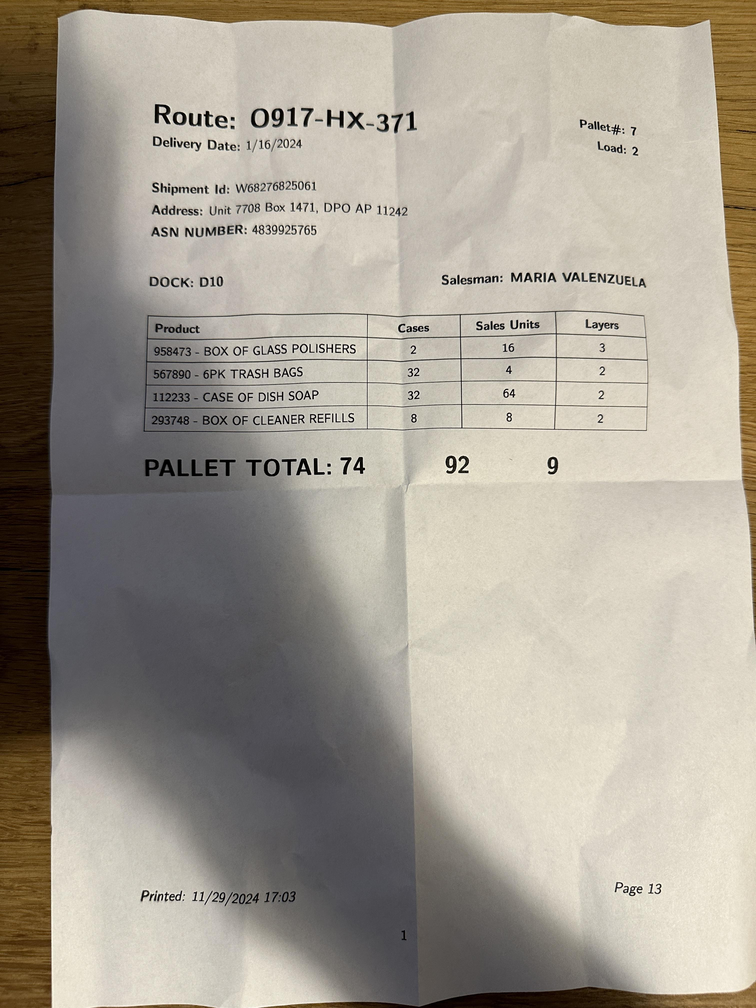

In [ ]:
scale_down_loaded_image(image)